# Fairground

This lab introduces _contextual multi-armed bandits_.
It is also an opportunity to train some neural networks with PyTorch (an alternative to TensorFlow and Jax - it's good to have experience of multiple tools).

The multi-armed bandit problem gets its name from the one armed bandit slot machine found in gambling dens (some of the earliest, very literally, had one arm: [one armed bandits](https://commons.wikimedia.org/wiki/File:One-Armed_Bandits_at_Stockmen%27s_Hotel,_Elko,_Nevada_(83581).jpg)).
It gets the term "_multi-armed bandit_" because we imagine a row of them, all with different payout rates, i.e. if you pull the lever of the best your average reward will be higher than if you selected any of the other machines.
The problem is we don't know which lever that is.

This gives rise to the _exploration_ vs _exploitation_ problem, a core part of reinforcement learning (bandits are not an example of reinforcement learning, as they don't have sequential decision making, but they make for an excellent gateway algorithm).
In this scenario we keep pulling arms, trying to maximise reward.
At any given moment you can either choose to explore, i.e. try an arm to improve your estimate of its payout rate, or exploit, i.e. pull the arm you believe has the highest payout rate.
Because there is noise in the payout you only ever have an estimate of the payout rate, e.g. it's entirely possible that a super rare event that substantially adjusts your estimates has yet to be observed, such as the jackpot.
This means that at any given moment your estimate of which arm is best could be wrong, hence the need to explore never goes entirely away, though it does go down as you learn which arm is best.

This problem may seem a little abstract at first, but it can be found in many places.
A classic example is picking a website design, which is called _A/B testing_.
You have two (or more) versions of a web page and want to know which is _best_, in some sense that you can measure.
One way to approach this is as a classic scientific experiment: show version A for a month, then show version B for a month, then look at the measurement and choose the best.
But that wastes two months, and doesn't help if you have twenty designs.
Instead, a bandit will gather information and softly commit to a solution as the evidence it's the right choice grows.
This same idea can be applied to the more serious problem of selecting which of several drugs is best for a condition.

Back to the internet and an example you will have suffered is the intrusive displaying of adverts on websites.
Each advert that could be displayed is a one armed bandit, and you want to place the advert with the highest payout, i.e. the one the user is most likely to click on.
This introduces context, as we probably have some cookies that tell us something about the user, so we can select an advert specifically for them, rather than whichever one gets the highest global click through rate.
The advert can also have an associated context.

For this lab the scenario is a little more fun:
you're coding a greeting robot at a fairground, so the job of the algorithm is to direct patreons to the ride that will make them happy.
Both the patreons and rides have context.
There are three questions that build up to a complete solution:

1. Ignore context to introduce Thompson sampling as a solution for the basic multi-armed bandit problem
2. Introduce PyTorch for training a neural network. This includes the context but to keep things simple there is no bandit; instead a neural network is trained once and then run, ignoring the exploration/exploitation problem entirely.
3. All together: using a neural network to do Thompson sampling for a contextual multi-armed bandit.


## Marking

This lab exercise has 10 marks to earn; they are formative and not actually worth anything towards your final grade.
Every place you have to add code is indicated by

`# **************************************************************** 2 marks`

with instructions above the code block.

You may submit your notebook to the auto marker [you.cs.bath.ac.uk](https://you.cs.bath.ac.uk) to get a grade.
The notebook you submit must be an .ipynb file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`.
Remember to save your work regularly (`Save and checkpoint` in the `File` menu, the icon of a floppy disk, or `Ctrl-S`); the version you submit should have all code blocks showing the results (if any) of execution below them.
It is wise to verify it runs to completion with _Restart & Run All_ before submission.

You must comply with the universities plagiarism guidelines: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

In [1]:
%matplotlib inline

import time

import numpy
import matplotlib.pyplot as plt

import torch

import fairground

The below generates a random fairground and some random visitors
It then assigns each random visitor to a random ride at the fairground and records the percentage that are happy.
We can consider this to be the baseline.

In [2]:
rng = numpy.random.default_rng()


# Generate a random fairground...
rides, ride_indices = fairground.generate_fairground(rng)
print('Fairground contains:')
fairground.print_names(ride_indices, indent=4)
print()


# Generate some random visitors...
visitors = fairground.patreons(1024 * 16, rng)


# Try random assignment to rides, so we have a baseline level of happiness...
print('Random ride assignment:')
which = rng.choice(rides.shape[0], size=visitors.shape[0])

assignment = numpy.empty((visitors.shape[0], 20))
assignment[:,:10] = visitors
assignment[:,10:] = rides[which,:]

h = fairground.happy(assignment, rng)
baseline = h.sum() / h.shape[0]

print('    {:.1f}% of customers happy'.format(100 * baseline))

Fairground contains:
    Reverse bungee
    Bungee trampolines
    Mechanical bull
    Go karts
    Fun slide
    Hayride
    Helter skelter
    Puny train ride
    Arcade hall
    Toboggan
    Dodgems
    Caterpillar
    Planetarium
    Rotor
    Pub
    Ferris wheel

Random ride assignment:
    29.9% of customers happy


## 1. Thompson sampling

Thompson sampling is a Bayesian solution to the bandit problem.
It's also pre-computer, dating from 1933, specifically the paper "_[On the likelihood that one unknown probability exceeds another in view of the evidence of two samples](https://www.gwern.net/docs/statistics/decision/1933-thompson.pdf)_" by Thompson.
Definitely not recommended reading - language has changed dramatically since it was published.
It's an example of a solution to a problem being forgotten, and then rediscovered many times when computers gave it a new reason to be relevant.
Keep in mind that there are dozens of approaches to solving bandit problems, and while Thompson sampling is one of the best it's in practise not the best approach all of the time.
It's one of the better ones however, and has convergence proofs.

Thompson sampling is simple to explain, if not always easy to implement.
Assuming you have a fully Bayesian model, that is you've got a PDF over model parameters, it consists of two steps:

1. Draw a specific model instance (sample the posterior of the Bayesian model).
2. Choose the best bandit according to the sampled model.
3. Update the Bayesian model with the result of choosing that bandit.

That's it!
Or at least, that's a single step - you repeat this for each iteration.
Because the distribution over model parameters represents our uncertainty the above selects each bandit proportional to it's probability of being the best.
This naturally balances exploration and exploitation (noting that the phrase "_naturally balances_" is scientifically meaningless).

For the fairground we'll presume that we score 0 if a patreon is unhappy and 1 if the patreon is happy.
Remember that we are ignoring context for now, so the model can be a set of Bernoulli distributions, one per ride.
The model is hence parameterised by the probability of each ride making a patreon happy.
To make the model Bayesian we need a prior over these parameters - the Beta distribution is the obvious choice because it is the conjugate prior to the Bernoulli.
This means we can start from a prior, specifically a $\operatorname{\beta eta}(1, 1)$ prior, as that's a uniform probability of each possible model values for each ride.
The process is hence:

1. Sample a happiness probability for each ride from the model (draw from Beta distributions).
2. Pick the ride with the highest happiness probability for the current patreon.
3. Observe if the patreon is happy and update the model (update Beta distribution parameters) accordingly.

The below code already includes the update, in that it keeps track of how many times each ride has resulted in a happy vs sad patreon and hands it to a function you need to fill in.
Your task is to code the function to return the index of the ride to send the patreon to, in compliance with Thompson sampling.

Notes:
* The `rng` parameter passed into `pick_thompson()` will be an instance of [numpy.random.Generator](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator) - it has methods to generate random numbers from all of the standard PDFs.
* This is very much an exercise in understanding the above - can be solved in two lines if you think it through! (and keep it vectorised)
* Make sure you don't get $\alpha$ and $\beta$, the parameters of the $\operatorname{\beta eta}$ distribution, backwards!

__(2 marks)__

In [3]:
def pick_thompson(sad, happy, rng):
    """This function is given two 1D arrays, indexed by ride, giving how many
    times each ride has made a customer sad and how many times it has made a
    customer happy. It returns the index of the ride to send a customer to.
    Also provided with a rng for the sampling."""

    # **************************************************************** 2 marks
    sample = rng.beta(happy+1,sad+1)
    return numpy.argmax(sample)


# Do a multi-armed bandit loop (not contextual) using the above pick_thompson() function...
sad = numpy.zeros(rides.shape[0], dtype=int)
happy = numpy.zeros(rides.shape[0], dtype=int)

print('Thompson sampling ride assignment:')
assignment = numpy.empty(20)

for row in visitors:
    choice = pick_thompson(sad, happy, rng)
    
    assignment[:10] = row
    assignment[10:] = rides[choice,:]
    
    h = fairground.happy(assignment, rng)
    (happy if h else sad)[choice] += 1


# Print performance...
thompson = happy.sum() / visitors.shape[0]
print('    {:.1f}% of customers happy'.format(100 * thompson))
print()


# Print how many times each ride was selected and the happiness it contributed...
print('Ride performance:')
for i, fi in enumerate(ride_indices):
    name = fairground.rides[fi]['name']
    usage = 100 * (sad[i] + happy[i]) / visitors.shape[0]
    happiness = 100 * happy[i] / numpy.maximum(sad[i] + happy[i], 1)
    print(f'  {name:>18}: usage = {usage:.1f}%, ride happiness = {happiness:.1f}%')


Thompson sampling ride assignment:
    46.2% of customers happy

Ride performance:
      Reverse bungee: usage = 0.2%, ride happiness = 23.1%
  Bungee trampolines: usage = 2.5%, ride happiness = 41.0%
     Mechanical bull: usage = 14.8%, ride happiness = 46.8%
            Go karts: usage = 4.3%, ride happiness = 43.3%
           Fun slide: usage = 0.2%, ride happiness = 12.0%
             Hayride: usage = 0.8%, ride happiness = 37.4%
      Helter skelter: usage = 0.5%, ride happiness = 29.5%
     Puny train ride: usage = 0.1%, ride happiness = 9.1%
         Arcade hall: usage = 21.6%, ride happiness = 46.2%
            Toboggan: usage = 0.5%, ride happiness = 26.7%
             Dodgems: usage = 52.3%, ride happiness = 48.0%
         Caterpillar: usage = 0.1%, ride happiness = 0.0%
         Planetarium: usage = 0.2%, ride happiness = 16.1%
               Rotor: usage = 0.8%, ride happiness = 36.5%
                 Pub: usage = 1.0%, ride happiness = 36.4%
        Ferris wheel: usage = 0

## PyTorch quick start

[PyTorch](https://pytorch.org) provides a simple workflow for generating neural networks within `torch.nn`.
We will not be using it.
Instead, we're going to implement the neural network at the same level as numpy, and only make use of the _automatic gradient_ calculation (autograd) for optimisation.
This allows you to calculate the gradient of any parameter relative to your loss function, so you can perform gradient descent (or a better alternative).

In Torch autograd is entirely explicit.
Firstly, you create arrays using functions such as `torch.zeros()` - these are equivalent to `numpy` arrays but with the extra functionality needed for automatic differentiation.
You then tell Torch which arrays you want gradients for; this can be done at construction
```
weights = torch.zeros(32, requires_grad=True)
```
or later
```
weights.requires_grad_()
```
Note that the underscore after the method call name indicates tht it is _in place_, that is it updates the weights array rather than returning a new array.
Enabling it later is usually done because you need to fill in the array in with some complex calculation first, and don't want to waste memory preparing to calculate the gradient of that calculation.

Once you have your arrays ready you can then do an arbitrary calculation on them (with `torch` only - if your calculation travels through `numpy` or traditional Python data structures then the connection will be broken and the gradient lost), which for machine learning will typically end up in the calculation of a `loss` that you want to minimise.
You can then call `loss.backward()` on this variable.
Every array for which you have enabled gradient calculation contains an additional parameter, `grad`, e.g. `weights.grad`.
It's another array, same shape as its parent, and after calling `loss.backward()` it will contain the gradient of that array with respect to `loss`.
This ability to calculate gradients automatically is the core of what makes PyTorch useful, and all we need to fit a neural network to data.

Note that there is one extra detail that can bite you.
`loss.backward()` doesn't replace the `.grad` arrays, instead it adds the gradient onto whatever is already in the `.grad` arrays.
This is convenient, as you can use this to send multiple blocks of data through, updating the gradient after each block with `.backward()` before doing an optimisation step.
But it does mean you must remember to zero out the gradients each time through the optimisation loop, e.g.
```
weights.grad.zero_()
```
Note again the use of an underscore to indicate it is inplace.

Two final details.
Sometimes you want to do some calculations without updating the gradients.
The most common example of this is when performing the actual update of your model parameters as part of each optimisation step.
This can be done with
```
with torch.no_grad():
    weights -= weights.grad * lr
```
In this example we have a traditional gradient descent update with `lr` as the learning rate (step size).

The second detail is that sometimes you want to keep a value around, when it was involved in gradient calculation, but without keeping the data structures required for gradient calculation.
A good example of this is keeping the history of training loss as a network is trained.
In fact, if you kept the computation graphs with the history the graph would get so big you would probably run out of memory!
In such cases you can use `.detach()`:
```
history.append(loss.detach())
```
Note that, as a safety feature, you can't convert a tensor to a `numpy` array unless you detach it first.


## 2a. Neural network with dropout

We're going to stick to a simple fully connected three layer neural network.
All this means is we're learning a function from a vector to a single value

$$y = f(\mathbf{x})$$

which happens in this case to take the form

$$y = \phi(\phi(\phi(\mathbf{x}^T \mathbf{W}_1 + \mathbf{b}^T_1) \mathbf{W}_2 + \mathbf{b}^T_2) \mathbf{W}_3 + \mathbf{b}^T_3)$$

where the $\mathbf{W}$ are matrices of weights and the $\mathbf{b}$ are column vectors of biases.
Note that because the output is a single value technically $\mathbf{W}_3$ is a vector and $\mathbf{b}_3$ is a single value; matrix/vector notation is preserved so this is in the general form (i.e. same notation if $y$ is a vector), including in the data structures.
Putting the input vector before the matrix happens to be convenient due to the way broadcasting works when it comes to the implementation.

The $\phi(\cdot)$ function is the nonlinearity, which is always defined elementwise (i.e. if you give it a vector it will return a vector of the same size where the function has been applied independently to each element).
In this case we're going to use the leaky ReLU (rectified linear unit), which can be defined as

$$\phi(v) = \begin{cases} v & \text{if}\ v>0 \\ 0.01 v & \text{otherwise} \end{cases}$$

$0.01$ is technically a parameter, but it's usually not worth tuning, and in this case should be left alone.

To understand the relationship between the above equation and the typical diagram note that each $\cdot \mathbf{W} + \mathbf{b}$ is the function for a linear transform representing the connections between layers and $\phi(\cdot)$ is the nonlinearity on each layer.
These two functions are just being alternated between, with function composition, with each pair making up a layer of a neural network, that is then passed to the next.
Writing it in terms of layer outputs, $\mathbf{l}$, gives you

$$\mathbf{l}_0 = \mathbf{x}^T$$

$$\mathbf{l}_n = \phi(\mathbf{l}_{n-1} \mathbf{W}_n + \mathbf{b}^T_n)$$



### Dropout

You'll note that Thompson sampling is dependent on having a Bayesian model, when the above neural network is not even probabilistic, let alone Bayesian.
Dropout is a technique that gives us a probabilistic network.
The original version consists of randomly dropping outputs from each layer during the training phase only (different draw for each exemplar), the idea being this improves robustness by preventing too much dependency on any single path through the network.
You can extend this by also randomly dropping connections during evaluation.
It has since been shown that this is, in a very specific sense, equivalent to a deep Gaussian process, with each noisy evaluation equivalent to a draw from the distribution.
A deep GP is when you take multiple GPs and compose the functions; it's Bayesian, at least in the sense required for Thompson sampling.

Modifying the three layer neural network equation to include dropout on just the first hidden layer it becomes

$$y = \phi(\phi([\phi(\mathbf{x}^T \mathbf{W}_1 + \mathbf{b}^T_1) \odot \mathbf{k}^T_1] \mathbf{W}_2 + \mathbf{b}^T_2) \mathbf{W}_3 + \mathbf{b}^T_3)$$

where $\odot$ is the Hadamard product (element wise) and

$$\mathbf{k}_1 \sim \operatorname{Bernoulli}(1 - d)$$

noting that the above is assumed to be vectorised, i.e. we do an independent draw from the Bernoulli distribution for each element of the vectors $\mathbf{k}_1$.
$d$ is the dropout rate, i.e. how often we lose an output from a layer.
It's common to set it to a different value for each layer, but we're only going to have it on one layer here.

Your task is to fill in the function `model()` below with the dropout version of a three layer NN with leaky ReLU.
Note that a dictionary containing parameters has been provided for you.
The input is a vector of length 20 (length of patreon feature vector + length of ride feature vector), the length of the first hidden layer should be of length 256 and the second hidden layer should be of length 128.
Output is of course a single value.
The dropout rate (probability of dropping a value) should be 0.25 for the first hidden layer only ($\mathbf{k}_1$).
You don't have dropout on the final layer, as randomly switching off the entire network would be silly.
The other layers have been dropped as we don't need that much randomness for this to work and it saves computation (drawing from a pdf is expensive).

Notes:
 * It must be properly vectorised, such that you can call `model()` with either a single vector or with a data matrix. This will naturally happen if you put the vector first. The `@` operator does matrix multiplication for the last two dimensions, broadcasted over the rest, automatically switching to vector-matrix multiplication as required. This includes `vector @ matrix` adding an implicit transpose. In other words it naturally does the right thing if you put the vector first. Broadcasting rules mean you don't have to transpose the bias either.
 * Broadcasting will add extra dimensions to the return value of `model()`. Return the [`.squeeze()`](https://pytorch.org/docs/stable/generated/torch.squeeze.html) of the calculated value, to remove those excess dimensions.
 * Torch can be very fussy about data types. If it complains that it needs a `Tensor` just convert, e.g. `torch.tensor(1.0)`
 * When using a library like PyTorch you should use the [random number generator](https://pytorch.org/docs/stable/torch.html#random-sampling) it provides. This is because this rng will also run on the GPU, which is important if you need the speed.
 * You may want to write your own leaky ReLU function (Torch does provide one, but where is the fun in using that?). Your choice though.
 * The auto marker won't give you a GPU when marking this, so while you can make the code use one if you want make sure it will gracefully degrade if one isn't available. It's certainly not needed.

If you're desperate for further reading then dropout was proposed in "_[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)_" by Srivastava, Hinton, Krizhevsky, Sutskever and Salakhutdinov (2014).
Doesn't really explain why.
For the relationship between dropout and deep GPs see "_[Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://proceedings.mlr.press/v48/gal16.pdf)_" by Gal and Ghahramani (2016).
Not an easy paper.
The weight initialisation approach used below is described in "_[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)_" by He, Zhang, Ren and Sun (2015).

__(2 marks)__

In [4]:
##### First we define model parameters...
# (I would normally put these in a class, but not everyone in the lab knows OOP hence doing
#  it this way. Do not change because auto marker depends on the model() function calling structure!)
theta = {}

theta['w',1] = torch.empty((20, 256), requires_grad=True)
theta['b',1] = torch.zeros(256, requires_grad=True)
theta['w',2] = torch.empty((256, 128), requires_grad=True)
theta['b',2] = torch.zeros(128, requires_grad=True)
theta['w',3] = torch.empty((128, 1), requires_grad=True)
theta['b',3] = torch.zeros(1, requires_grad=True)


# We need to initialise model parameters - we can't just set them to zero as that doesn't work
# because optimisation will get stuck on ties (values will move in lockstep; doesn't happen 
# for bias due to weights being random however).
# Instead we fill them with random noise that has been very carefully selected to work well
# for the specific layer structure/non-linearity (see above for reference).
# Note that disabling the gradient avoids wasting the memory taken up by the data structure
# it builds in anticipation of calculating gradients. In a function so it can be reused below.
def init():
    with torch.no_grad():
        for name in [('w',1), ('w',2), ('w',3)]:
            theta[name][...] = torch.randn(size=theta[name].shape) * numpy.sqrt(2 / theta[name].shape[0])

init()


def leakyReLU(v):
    """Implementation of a leaky ReLU, just because:-P"""
    return torch.maximum(torch.tensor(0), v) + 0.01 * torch.minimum(torch.tensor(0), v)


def model(x, theta):
    """This should implement the neural network function, taking in x and returning y.
    It also takes a dictionary of parameters, called theta."""
    
    # **************************************************************** 2 marks
    d = 0.25
    k = torch.bernoulli(torch.full((256,),1-d))
    v = leakyReLU(x@theta['w',1]+theta['b',1])*k
    for i in range(2,4):
        v = leakyReLU(v@theta['w',i]+theta['b',i])
    return v.squeeze()


# A quick test of the model - weights are obviously wrong, so answer will be random,
# but checks it runs without error...
# (Ignore grad_fn - it's the link to the computation graph, as used for calculating gradients)
print('Zero:', model(torch.zeros(20), theta)) # bias is zero so this should return 0!
print('Random:', model(torch.rand(20), theta)) # Single random value; if return is 1D you need to .squeeze()!
print('Block:', model(torch.rand((7,20)), theta)) # Vectorisation test; if return is 2D you need to .squeeze()!


Zero: tensor(0., grad_fn=<SqueezeBackward0>)
Random: tensor(-0.0043, grad_fn=<SqueezeBackward0>)
Block: tensor([-0.0004, -0.0033, -0.0044, -0.0045, -0.0032, -0.0013, -0.0002],
       grad_fn=<SqueezeBackward0>)


## 2b. Realistic training

We want to obtain a fair comparison with both the baseline and Thompson sampling from earlier, so we can see how this approach performs relative to them both.
But the neural network won't work without training data, and it wouldn't be fair to give it any before the customers arrive!
Instead, we take a batch learning approach: random assignment for the first 50% of customers, then use them (with their random assignments) as the training data for the neural network, before making the decision for the remaining 50% of customers with the trained network.
This is fair because the network gets the same data in the same order, as long as we report the overall performance for 100% of customers (both those who got random assignment and those who got a decision from the network).
We'll also report the performance on the last 50% only however, to get a sense of where the network would end up in a fairground that's open for longer, but note that this number is not comparable to the others.

To train the network we need a _cost function_.
For this first version we're just going to use root mean squared error (RMSE),

$$\sqrt{\sum_i \left( y_i - f(x_i, \theta) \right)^2}$$

where $f(x, \theta)$ is the neural network.
This doesn't work if using the network within Thompson sampling, but it works fine for the batch approach being taken so we'll make the necesary change in Q3.

The batch learning code is provided below, including the code to train the network with the above cost function, so the above is entirely for explanation.
Your task is to finish the function that selects the ride for each vistor, that is only run after the network has been trained.
However, note that the neural network is noisy due to dropout.
This means that to evaluate how good a sample is you must run the network many times, and then generate a summary of the samples; in this case you must take the mean.
The `pick_nn()` function includes a samples parameter, which is how many samples per ride to do.

Notes:
* This will be very slow if you call `model()` for every sample and ride combination. You'll want to use broadcasting in other words!
* You should use `with torch.no_grad():` as the gradient isn't required and that will make it faster still.
* Remember that the `model()` function takes the customers vector concatenated to the rides vector. Many ways of doing this, but [`cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) is one choice. [`repeat()`](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) and broadcasting is another.
* You can find the ride vectors in the `rides` array, which is indexed `[ride, feature]`. Be aware that it's a `numpy` array, not a `torch` `Tensor`, so conversion has to happen, though most solutions will do so automatically.
* This takes about 16 seconds using 32 cores running at 4.5Ghz. It will take some time, but it should remain reasonable even on slower computers. I hope! You can run with a reduced epoch count if you want.
* This won't always beat Thompson sampling (above), because it's being stupid for the first half of the customers. Should beat Thompson sampling for the second half however!

__(2 marks)__

Took 44.7 seconds
Training curve:


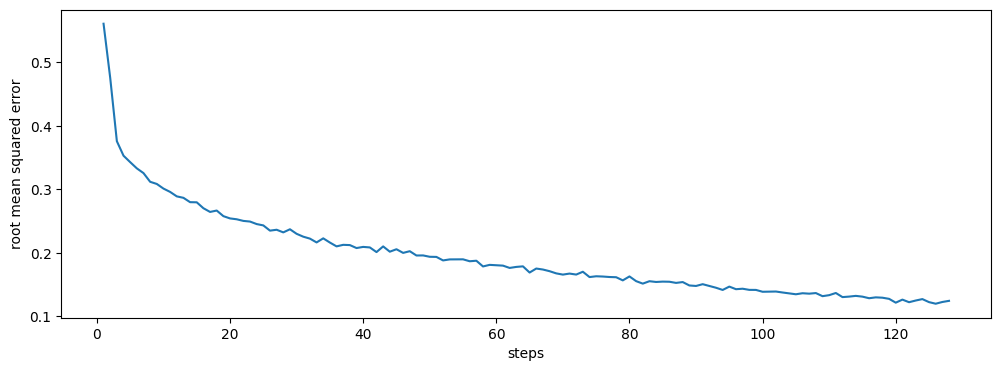

Batch neural network ride assignment:
    52.5% of customers happy
    75.1% of nn customers happy


In [5]:
def pick_nn(visitor, theta, samples = 16):
    """Given a 1D feature vector representing a customer this must return the
    index of the best ride for that customer. samples is the number of samples
    it should take to determine this."""

    # **************************************************************** 2 marks
    with torch.no_grad():
        x = torch.cat((visitor.expand(rides.shape[0],visitor.shape[0]),torch.from_numpy(rides)),
                       dim=1).unsqueeze(0).repeat([samples]+[1]*2).to(torch.float32)
        return torch.argmax(model(x,theta).mean(dim=0))


# Build the training set by handling the first 50% of customers randomly...
half = visitors.shape[0] // 2

which = rng.choice(rides.shape[0], size=half)

train_x = numpy.empty((half, 20))
train_x[:,:10] = visitors[:half,:]
train_x[:,10:] = rides[which,:]

train_y = fairground.happy(train_x, rng)

     
# Train neural network using stochastic gradient descent...
epochs = 128
batch_size = 64
history = []

init()
start_time = time.time()
for epoch in range(epochs):
    # Create a random ordering for assigning visitors to mini-batches...
    order = torch.randperm(half)
    
    # Process each mini-batch...
    losses = []
    for base in range(0, half, batch_size):
        batch_x = torch.tensor(train_x[order[base:base+batch_size],:]).float()
        batch_y = torch.tensor(train_y[order[base:base+batch_size]]).float()
        
        # Reset gradients (if they exist)...
        for param in theta.values():
            if param.grad is not None:
                param.grad.zero_()
        
        # Calculate loss (rmse)...
        pred_y = model(batch_x, theta)
        loss = torch.sqrt(torch.square(batch_y - pred_y).mean())
        
        losses.append(loss.detach())
        
        # Backpropagation...
        loss.backward()
    
        # Take a step with gradient descent...
        # (PyTorch does of course include libraries to do this, but want
        # to show what they actually do, even though this is super basic
        # and a terrible choice)
        step_size = 0.5 * (epochs - epoch) / epochs # This is a simple learning schedule
        with torch.no_grad():
            for param in theta.values():
                param -= step_size * param.grad
        
    # Record performance (should really calculate, rather than taking the
    # average of the minibatches, as they are out of date, but this
    # gets a reasonable approximation quickly. Should also have a validation
    # set, but that's awkward in this scenario)...
    history.append(numpy.array(losses).mean())

end_time = time.time()
print('Took {:.1f} seconds'.format(end_time - start_time))


# Generate a graph of iteration vs performance for nn...
print('Training curve:')
plt.figure(figsize=(12, 4))
plt.xlabel('steps')
plt.ylabel('root mean squared error')

plt.plot(numpy.arange(len(history)) + 1, history)
plt.show()


# Do the remaining 50% of customers using the network...
happy = numpy.empty(visitors.shape[0] - half, dtype=int)

for i in range(happy.shape[0]):
    choice = pick_nn(torch.tensor(visitors[half+i,:]), theta)
    happy[i] = fairground.happy(numpy.concatenate((visitors[half+i,:], rides[choice,:])), rng)


# Report performance...
print('Batch neural network ride assignment:')
print('    {:.1f}% of customers happy'.format(100 * (train_y.sum() + happy.sum()) / visitors.shape[0]))
print('    {:.1f}% of nn customers happy'.format(100 * happy.sum() / happy.shape[0]))
